# Qwen3-VL Local Inference Examples

This notebook demonstrates how to use the `infer.py` module for Qwen3-VL inference.

## Setup


In [ ]:
# Install required packages (run once)
%pip install "transformers>=4.57.0" torch torchvision pillow

# Optional: for faster inference
# %pip install flash-attn --no-build-isolation


In [2]:
# Auto-reload modules when they change (useful for development)
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import os
from PIL import Image

# Import inference functions from infer.py
from infer import load_model, prepare_messages, run_inference

# Check environment
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.9.0
CUDA available: False


## 1. Load Model

Choose a model size based on your GPU memory:
- `Qwen/Qwen3-VL-2B-Instruct` - ~8GB VRAM (fastest)
- `Qwen/Qwen3-VL-4B-Instruct` - ~12GB VRAM
- `Qwen/Qwen3-VL-8B-Instruct` - ~20GB VRAM
- `Qwen/Qwen3-VL-32B-Instruct` - ~48GB VRAM


In [3]:
# Configuration
MODEL_PATH = "Qwen/Qwen3-VL-2B-Instruct"  # Change to your preferred model

# Load model using the load_model function from infer.py
print("Loading model... (this may take a few minutes on first run)")
model, processor = load_model(
    model_path=MODEL_PATH,
    use_flash_attn=False  # Set to True if you have flash-attn installed
)


Loading model... (this may take a few minutes on first run)
Loading model from: Qwen/Qwen3-VL-2B-Instruct


`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded successfully on device: mps:0


## 2. Helper Function

We'll use the functions from `infer.py`:
- `prepare_messages()` - Formats input for the model
- `run_inference()` - Runs inference and returns output


In [4]:
def inference_image(image_path, prompt, max_new_tokens=512):
    """Wrapper function using infer.py functions."""
    # Prepare messages using the imported function
    messages = prepare_messages(
        media_paths=image_path,
        prompt=prompt,
        media_type="image"
    )
    
    # Run inference using the imported function
    output = run_inference(model, processor, messages, max_new_tokens)
    return output

print("Helper function defined using infer.py!")


Helper function defined using infer.py!


## 3. Example 1: Image Description


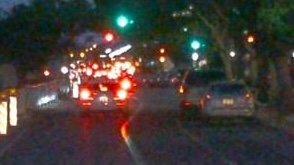


Prompt: Describe this image in detail.

Response:
This is a low-resolution, blurry image of a nighttime street scene, likely captured from a dashcam or a vehicle's perspective. The image is dominated by the bright red and white lights of a traffic jam.

The scene is viewed from a side angle, looking down a road that appears to be a multi-lane highway or major road. The central focus is a dense traffic flow, with a large number of vehicles, mostly appearing as red taillights. The vehicles are tightly packed, suggesting heavy congestion.

On the right side of the image, a light-colored sedan is visible, and its rear lights are on. The road is flanked by trees and streetlights, which are also illuminated. The overall lighting is dim, with the primary sources of light being the vehicle lights and the streetlights, creating a contrast between the dark surroundings and the bright lights.

The image quality is very low, with significant blur and noise, which obscures fine details. The colors

In [5]:
# Use test images from local directory
test_images_dir = Path("../data/test_images")
test_image_path = test_images_dir / "night_camera_1_time_1558060923374527_img_0_focus.jpeg"

# Load and display the image
img = Image.open(test_image_path)
display(img)

# Run inference
prompt = "Describe this image in detail."
result = inference_image(str(test_image_path), prompt)

print(f"\nPrompt: {prompt}")
print(f"\nResponse:\n{result}")


## Example 2: Direct Usage of infer Functions


In [ ]:
# Direct usage without wrapper function
prompt = "What objects can you identify in this image?"

# Prepare messages
messages = prepare_messages(
    media_paths=str(test_image_path),
    prompt=prompt,
    media_type="image"
)

# Run inference
result = run_inference(model, processor, messages, max_new_tokens=512)

print(f"Prompt: {prompt}")
print(f"\nResponse:\n{result}")


## Example 3: With System Prompt


In [ ]:
# Using a custom system prompt
messages = prepare_messages(
    media_paths=str(test_image_path),
    prompt="Analyze the visibility conditions and lighting in this driving scene.",
    media_type="image",
    system_prompt="You are an expert autonomous driving systems analyst."
)

result = run_inference(model, processor, messages, max_new_tokens=512)
print(f"Response:\n{result}")


## Example 4: Video Temporal Analysis

Analyze a sequence of frames to understand temporal behaviors and motion in the scene.


In [ ]:
# Load a sequence of frames from the test_video directory
video_frames_dir = Path("../data/v1.0-mini/samples/CAM_FRONT/test_video")

# Get sorted list of frame files (sorted by timestamp in filename)
frame_files = sorted(video_frames_dir.glob("*.jpg"))

# Select a subset of frames (e.g., every 4th frame to cover ~2 seconds at 2Hz)
# This helps capture temporal changes without overloading the model
selected_frames = frame_files[::4][:4]  # Take 8 frames with 4-frame intervals

print(f"Total frames available: {len(frame_files)}")
print(f"Selected {len(selected_frames)} frames for analysis:")
for i, frame in enumerate(selected_frames):
    print(f"  Frame {i+1}: {frame.name}")


In [ ]:
# Display a few sample frames to visualize the sequence
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(16, 8))
axes = axes.flatten()

for i, frame_path in enumerate(selected_frames):
    img = Image.open(frame_path)
    axes[i].imshow(img)
    axes[i].set_title(f"Frame {i+1}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("\nThese frames represent a temporal sequence from a vehicle's front camera.")


In [ ]:
# Prepare messages with multiple frames for temporal analysis
# Note: We use media_type="image" to pass multiple frames
# The model will analyze them as a sequence

frame_paths = [str(frame) for frame in selected_frames]

temporal_prompt = """Analyze this sequence of frames from an ego vehicle's front camera in chronological order.
Focus specifically on detecting lane changes and cut-in behaviors

If no cut-in is detected, clearly state that all vehicles maintained their lanes throughout the sequence."""

messages = prepare_messages(
    media_paths=frame_paths,
    prompt=temporal_prompt,
    media_type="image"
)

# Run inference to analyze temporal behaviors
# Note: This may take longer as we're processing multiple frames
temporal_result = run_inference(model, processor, messages, max_new_tokens=1024)

print("Temporal Analysis Result:")
print("=" * 80)
print(temporal_result)
print("=" * 80)
